# Simple CNN for compare default parameters in further applications
#### Previous adversial ensemble network will be created in another file

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #If using Matplotlib on Windows with different versions, this will surpress error
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy import ndimage #Image Smoothing
from collections import Counter

import sys
sys.path.append('../src/functions')
from clean_nn_weights import reset_weights    

Define dataloader parameter

In [2]:
batch_size_train = 32
batch_size_test = 32
random_seed = 1337
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)  #Static random seed for reproducibility

Load MNIST Dataset from torchvision

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, drop_last=True,worker_init_fn=random_seed)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True,drop_last=True,worker_init_fn=random_seed)

#### Quick analysis of class balances

In [40]:
print(train_loader.dataset.train_data.size())
print(test_loader.dataset.test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [41]:
nr_train = np.array([])
for i, (data, target) in enumerate(train_loader):
    nr_train=np.append(nr_train, target.cpu().detach().numpy())

nr_test = np.array([])
for i, (data, target) in enumerate(test_loader):
    nr_test=np.append(nr_test, target.cpu().detach().numpy())

In [14]:
Counter(np.sort(nr_train))

Counter({0.0: 6902,
         1.0: 7875,
         2.0: 6988,
         3.0: 7140,
         4.0: 6822,
         5.0: 6311,
         6.0: 6874,
         7.0: 7292,
         8.0: 6824,
         9.0: 6956})

In [11]:
Counter(np.sort(nr_test))

Counter({0.0: 979,
         1.0: 1133,
         2.0: 1030,
         3.0: 1009,
         4.0: 980,
         5.0: 890,
         6.0: 956,
         7.0: 1027,
         8.0: 973,
         9.0: 1007})

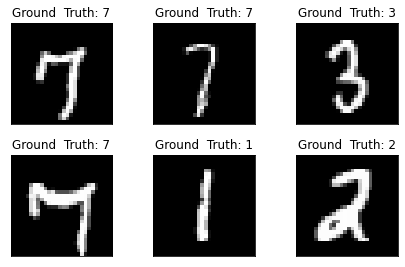

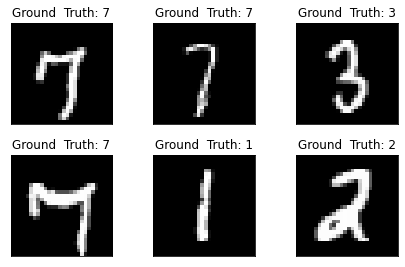

In [4]:
# Quick example of images
examples = enumerate(test_loader,start=0)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground  Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [4]:
def extract_dataloader_images(epoch):
  #for batch_idx, (data, target) in enumerate(train_loader):
  examples = enumerate(test_loader,start=0)
  _, (example_data, example_targets) = next(examples)
  return(example_data, example_targets)

def count_perturbated_pixel(img1,img2):
  sum_px = 28*28
  sum_px_perturbed = 0
  for px_img1,px_img2 in zip(x_d[0][0],f_d[0][0]): #Zip Array of Pixels
    for px_im1,px_im2 in zip(px_img1,px_img2): #Zip Pixels
        if (px_im1 != px_im2):
            sum_px_perturbed+=1
  return((sum_px_perturbed/sum_px),sum_px,sum_px_perturbed)

def perturbate_image(img_data,mode='random',value=100):
  if (mode=='random'):
      for i in range(value):
          img_data[0][0][random.randrange(1,28),random.randrange(1,28)]=random.uniform(min(np.ravel(img_data)),max(np.ravel(img_data)))
  elif (mode=='random_white'):
      for i in range(value):
          img_data[0][0][random.randrange(1,28),random.randrange(1,28)]=round(max(np.ravel(img_data)))
  return(img_data)

def median_smoothing(img_data,kernel_size=2):
  from scipy import ndimage
  print(img_data.shape.__len__())
  if (img_data.shape.__len__() > 2):
    for i in range(img_data.shape[0]):
      img_data[i][0] = torch.from_numpy(ndimage.median_filter(img_data[i][0], size=kernel_size))
  else:
    img_data = torch.from_numpy(ndimage.median_filter(img_data, size=kernel_size))
  return(img_data)

def bit_reduction(img_data,clip_min=0.5,clip_max=0.9):
  reduced_data = (img_data-min(np.ravel(img_data))) / (max(np.ravel(img_data)) - min(np.ravel(img_data)))
  reduced_data = reduced_data.clip(min=clip_min,max=clip_max)
  return(reduced_data)



def test_fake(data):
  network.eval()
  with torch.no_grad():
      output = network(data)
      return output

In [5]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [6]:
class simple_net_upgraded(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=800, out_features=500)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.5)
		self.fc2 = nn.Linear(in_features=500, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [187]:
class simple_net_upgraded_t(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded_t, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=800, out_features=500)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.5)
		self.fc2 = nn.Linear(in_features=500, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [153]:
class simple_net_upgraded2(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded2, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=30,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2 = nn.Conv2d(in_channels=30, out_channels=75,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2), stride=(2, 2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=1200, out_features=900)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.3)
		self.fc2 = nn.Linear(in_features=900, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [184]:
class simple_net_upgraded3(nn.Module): # This is the same as the previous one, but with a different (and more easy to understand) architecture. It has a few more neurons in each layer, replaced x.view(-1, 320) with linear layer. Replaced functional dropout with nn.dropout.
	def __init__(self, numChannels, classes):
		super(simple_net_upgraded3, self).__init__()

		self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=50,
			kernel_size=(5, 5))
		self.relu1 = nn.ReLU()
		self.maxpool1 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2 = nn.Conv2d(in_channels=50, out_channels=125,
			kernel_size=(5, 5))
		self.relu2 = nn.ReLU()
		self.maxpool2 = nn.MaxPool2d(kernel_size=(2), stride=(2))

		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(in_features=2000, out_features=1000)
		self.relu3 = nn.ReLU()
		self.dropout_l = nn.Dropout(p=0.2)
		self.fc2 = nn.Linear(in_features=1000, out_features=classes)

	def forward(self, x):

		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		x = self.conv2_drop(x)
		x = torch.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.dropout_l(x)
		x = self.fc2(x)
		return x

In [249]:
log_interval = 187 #60000/batch_size_train = 1875 => 10 Datapoints per Epoch => 187 Logs per Epoch
n_epochs = 20
learning_rate = 0.007
momentum = 0.5
load_data = 1
use_upgraded_net = 1
use_ensemble = 0
##########
save_net = 0
##########

if (use_upgraded_net == 1):
    network = simple_net_upgraded(1,10)
    network.apply(reset_weights)
    print ("Using Upgraded Net")
    if (use_ensemble == 1):
        network2 = simple_net_upgraded2(1,10)
        network3 = simple_net_upgraded3(1,10)
        
        network2.apply(reset_weights)
        network3.apply(reset_weights)

        print("Using Ensemble")
    
else:
    network = simple_net()
    network.apply(reset_weights)
    print ("Using Basic Net")


#device = "cuda:0"
#network.to(device)
if (use_ensemble == 0):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
if (use_ensemble == 1):
    optimizer_ensemble = optim.SGD(list(network.parameters())+list(network2.parameters())+list(network3.parameters()), lr=learning_rate, momentum=momentum)
    print("Loaded Optimizer for Ensemble")
if (load_data and use_upgraded_net == 0):
    network.load_state_dict(torch.load('../src/results/model.pth'))
    print('Loaded model from file')
    optimizer.load_state_dict(torch.load('../src/results/optimizer.pth'))
    print('Loaded optimizer from basic model')
if (load_data and use_upgraded_net == 1):
    if (use_ensemble==1):
        network.load_state_dict(torch.load('../src/results/model_upgraded_ens.pth'))
        network2.load_state_dict(torch.load('../src/results/model2_upgraded_ens.pth'))
        network3.load_state_dict(torch.load('../src/results/model3_upgraded_ens.pth'))
        print('Loaded upgraded ensemble model from file')
        optimizer_ensemble.load_state_dict(torch.load('../src/results/optimizer_ensemble.pth'))
        print('Loaded ensemble optimizer from upgraded model')
    else:
        network.load_state_dict(torch.load('../src/results/model_upgraded.pth'))
        print('Loaded upgraded model from file')
        optimizer.load_state_dict(torch.load('../src/results/optimizer_upgraded.pth'))
        print('Loaded optimizer from upgraded model')
if (save_net==1):
    print('WARNING: Saving model to file!! Will overwrite existing file!!!')

Reset trainable parameters of layer = Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=800, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=10, bias=True)
Using Upgraded Net
Loaded upgraded model from file
Loaded optimizer from upgraded model


In [247]:
def train(epoch,use_ensemble=0):
  network.train()
  if (use_ensemble==1):
    network2.train()
    network3.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if (use_ensemble == 1):
      optimizer_ensemble.zero_grad()
      output1 = network(data)
      output2 = network2(data)
      output3 = network3(data)
      output = (output1 + output2 + output3)/3 # Average of three networks...not used here but it is usefull in test. You could also use the aggregated output as for the loss but that can result in false weight balancings when a specific model has made a false prediction. Need more literature checking!
      #loss = F.cross_entropy(output, target)
      #loss.backward()
      loss1 = F.cross_entropy(output1, target)
      loss2 = F.cross_entropy(output2, target)
      loss3 = F.cross_entropy(output3, target)
      loss = (loss1 + loss2 + loss3)
      loss.backward()
      optimizer_ensemble.step()
    else:
      optimizer.zero_grad()
      output = network(data)
      loss = F.cross_entropy(output, target)
      loss.backward()
      optimizer.step()
    
    
    
    if (batch_idx % log_interval == 0) and (batch_idx != 0):
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      if (use_ensemble==1):  
        print('Loss 1: {:.6f}'.format(loss1.item()))
        print('Loss 2: {:.6f}'.format(loss2.item()))
        print('Loss 3: {:.6f}'.format(loss3.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
#https://discuss.pytorch.org/t/optimizing-based-on-another-models-output/6935/14
#https://discuss.pytorch.org/t/using-a-combined-loss-to-update-two-different-models/73925
      

In [245]:
def test(use_ensemble=0):
  network.eval()
  if use_ensemble==1:
    network2.eval()
    network3.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      if use_ensemble==1:
        output2 = network2(data)
        output3 = network3(data)
        output = (output + output2 + output3)/3# Average of three networks. Alternative is to use majority voting using output.data.max(1)[1] for each output and write it to an array to get argmax

      test_loss += F.cross_entropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  acc = 100. * correct / len(test_loader.dataset)
  test_acc.append(acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [250]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc = []
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

if (use_upgraded_net==0 and save_net==1):
  torch.save(network.state_dict(), '../src/results/model.pth')
  torch.save(optimizer.state_dict(), '../src/results/optimizer.pth')
  print("Saved Modell to file")
elif (use_upgraded_net==1 and save_net==1):
  
  if (use_ensemble == 1):
      torch.save(network.state_dict(), '../src/results/model_upgraded_ens.pth')
      torch.save(network2.state_dict(), '../src/results/model2_upgraded_ens.pth')
      torch.save(network3.state_dict(), '../src/results/model3_upgraded_ens.pth')
      torch.save(optimizer_ensemble.state_dict(), '../src/results/optimizer_ensemble.pth')
  else:
      torch.save(network.state_dict(), '../src/results/model_upgraded.pth')
      torch.save(optimizer.state_dict(), '../src/results/optimizer_upgraded.pth')
  print("Saved Modell to file")
save_net = 0 #Secure that only one model is saved


Test set: Avg. loss: 0.0006, Accuracy: 9924/10000 (99%)

Train Epoch: 1 [5984/60000 (10%)]	Loss: 0.082740
Train Epoch: 1 [11968/60000 (20%)]	Loss: 0.135509


KeyboardInterrupt: 

## SGD

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

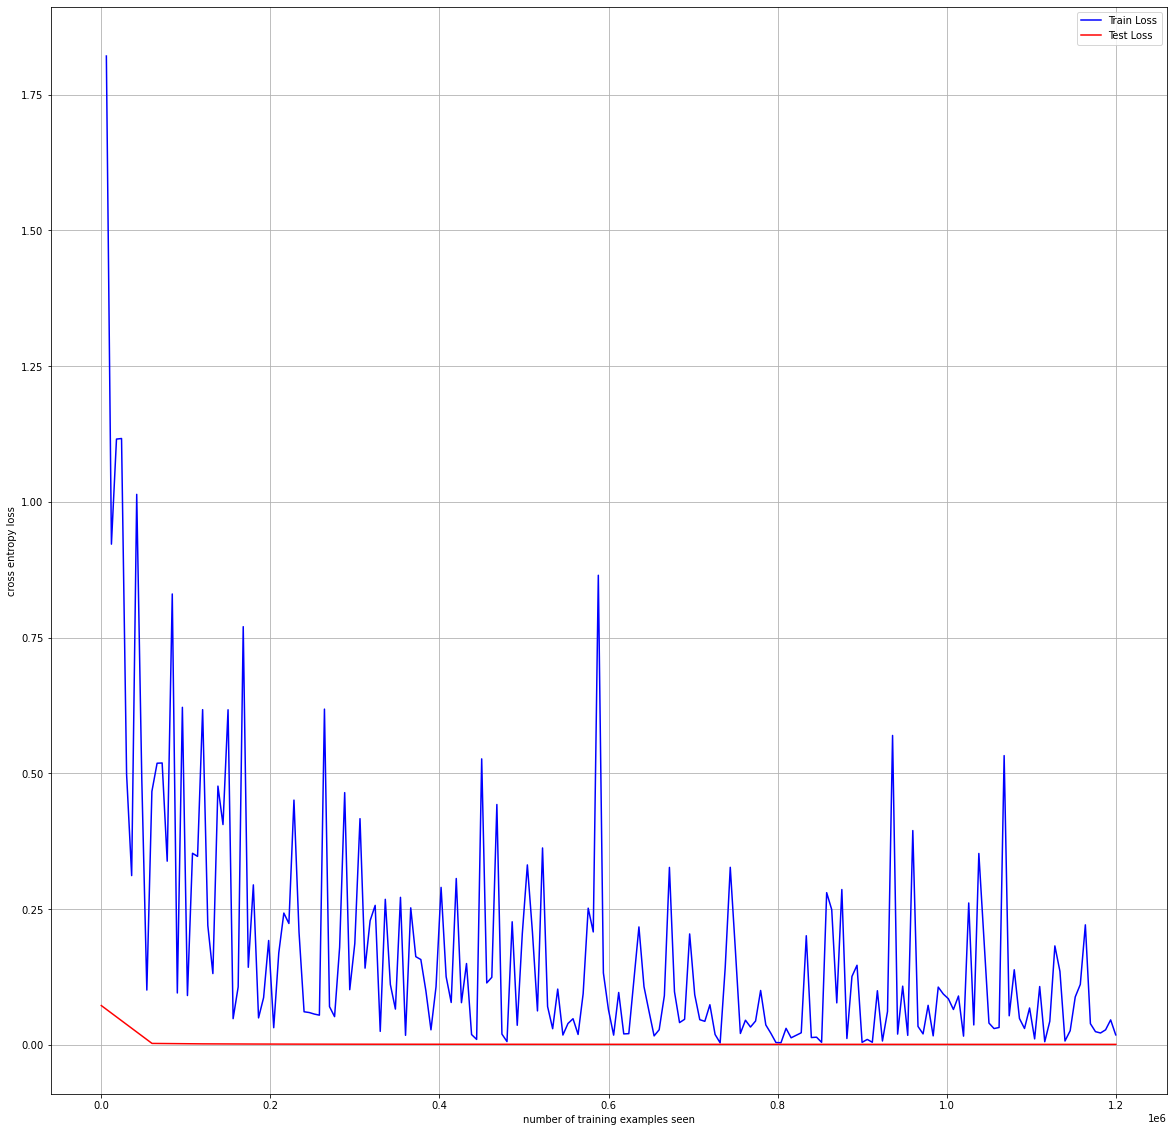

In [238]:
fig = plt.figure()
plt.figure(figsize=(20,20))
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')
plt.grid()
fig

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

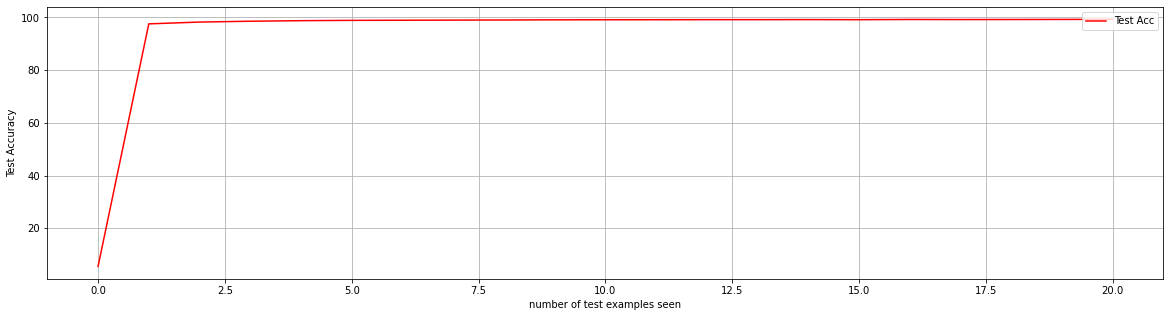

In [239]:
fig = plt.figure()
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(0,21), test_acc, color='red')
plt.legend(['Test Acc'], loc='upper right')
plt.xlabel('number of test examples seen')
plt.ylabel('Test Accuracy')
fig

# Documentation

##### ___Params___
##### Epochs: 20
##### b_size = 32
##### Optimizer = SGD
##### Momentum = 0.5
##### LR = 0.01
##### ___RESULTS___
##### Train Epoch: 20 [59840/60000 (100%)]	Loss: 0.141315
##### Test set: Avg. loss: 0.0337, Accuracy: 9881/10000 (99%)


### Perturabation mesasurement

In [240]:
x_d,e_d=extract_dataloader_images(0)
f_d=torch.clone(x_d)
p_d=torch.clone(x_d)
print("Min: {}".format(min(np.ravel(x_d))))
print("Max: {}".format(max(np.ravel(x_d))))

Min: -0.4242129623889923
Max: 2.821486711502075


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

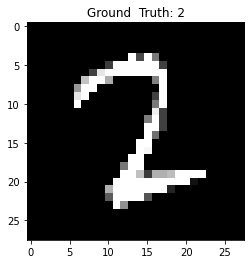

In [249]:
plt.imshow(scaled_data[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[0]))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

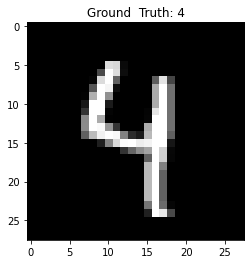

In [274]:
plt.imshow(f_d[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[0]))
plt.plot


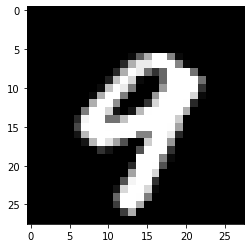

In [55]:
plt.imshow(ndimage.median_filter(f_d[0][0], size=2), cmap='gray', interpolation='none')

2


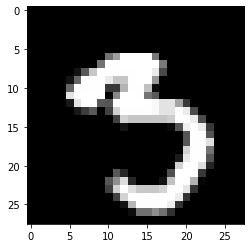

In [167]:
plt.imshow(median_smoothing(f_d[0][0]), cmap='gray', interpolation='none')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

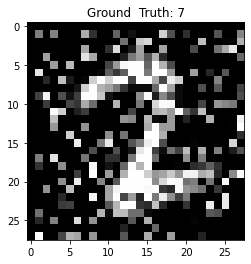

In [258]:
plt.imshow(pertubated_image[0][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

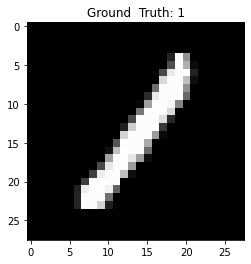

In [78]:
plt.imshow(x_d[5][0], cmap='gray', interpolation='none')
plt.title("Ground  Truth: {}".format(e_d[5]))
plt.plot

In [241]:
median_smoothed = median_smoothing(f_d)
scaled_data = bit_reduction(f_d)
pertubated_image = perturbate_image(p_d,mode='random') #Pertubations seems to make in-place operations so use different tensor

4


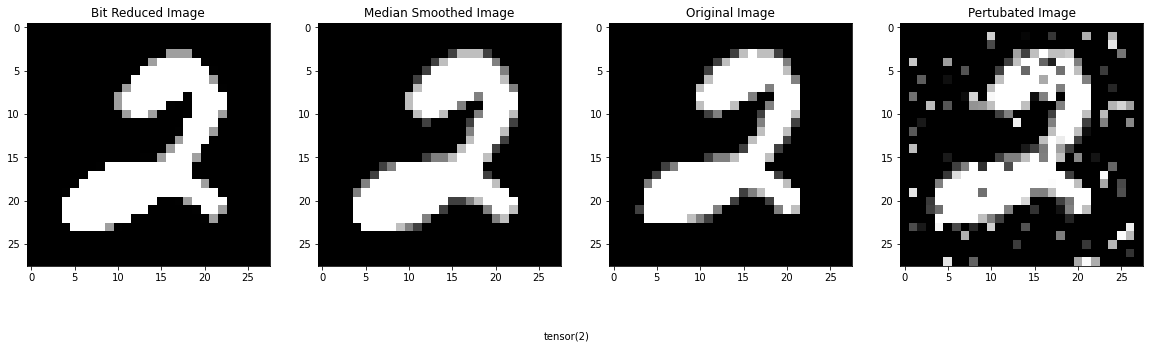

In [242]:
batch_nr = 0
fig = plt.figure()

ax1 = fig.add_subplot(141)  # left side
ax2 = fig.add_subplot(142)  # right side
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.title.set_text("Bit Reduced Image")
ax2.title.set_text("Median Smoothed Image")
ax3.title.set_text("Original Image")
ax4.title.set_text("Pertubated Image")
ax1.imshow(scaled_data[batch_nr][0], cmap='gray', interpolation='none')
ax2.imshow(median_smoothed[batch_nr][0], cmap='gray', interpolation='none')
ax3.imshow(x_d[batch_nr][0], cmap='gray', interpolation='none')
ax4.imshow(pertubated_image[batch_nr][0], cmap='gray', interpolation='none')
fig.text(.5, .05, e_d[batch_nr], ha='center')
fig.set_figheight(6)
fig.set_figwidth(20)
#plt.title("Ground  Truth: {}".format(e_d[batch_nr]))
plt.show()

### Test robustness of model

In [293]:
fake_tst = test_fake(f_d)
p_percent,p_size,p_pertubated=count_perturbated_pixel(x_d[0][0],f_d[0][0])
print("Model predicted: {}".format(fake_tst.data.max(1, keepdim=True)[1][0]))
print("Model real: {}".format(e_d[0]))
print("Sum pixel: {}".format(p_size))
print("Pertubated pixel: {}".format(p_pertubated))
print("Percent preturbated: {}".format(p_percent))

Model predicted: tensor([9])
Model real: 9
Sum pixel: 784
Pertubated pixel: 123
Percent preturbated: 0.1568877551020408
